In [1]:
import qutip
import numpy as np
import matplotlib.pyplot as plt

# Introduction
We shall be using qutrits to describe the three states involved in the controlled-z gates using a rydberg excited state $|r\rangle$ in addition to the hyperfine ground $|g\rangle$ and excited states $|e\rangle$ used for the digital basis. This corresponds to a "Vee" configuration for three-level systems:
<img src="files/three_states.png" alt="Three-state Configuration" style="width: 300px;"/>


# Basic Definitions

First we construct the basic states and operators:

In [2]:
# Three-state basis:
rydberg = qutip.Qobj([[1],[0],[0]])
excited = qutip.Qobj([[0],[1],[0]])
ground = qutip.Qobj([[0],[0],[1]])

In [3]:
# Basic transition operators:
identity = qutip.qeye(3)

rydX = qutip.Qobj([[0,0,1],[0,0,0],[1,0,0]])
rydY = qutip.Qobj([[0,0,-1j],[0,0,0],[1j,0,0]])
rydZ = qutip.Qobj([[1,0,0],[0,0,0],[0,0,-1]])

excX = qutip.Qobj([[0,0,0],[0,0,1],[0,1,0]])
excY = qutip.Qobj([[0,0,0],[0,0,-1j],[0,1j,0]])
excZ = qutip.Qobj([[0,0,0],[0,1,0],[0,0,-1]])

In [4]:
excZ

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0. -1.]]

Check these definitions work well

In [5]:
print(rydX * ground) # Gives rydberg
print(excX * ground) # Gives excited
print(rydX * rydberg) # Gives ground
print(rydX * excited) # Gives null vector

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]]


# General Rotation
Let's construct a rotation operator on the qutrit, which represents the pulses acting in our three-level system. Each pulse is characterized by an amplitude $\Omega$ and frequency $\delta$ 

In [6]:
# Using Rotating Wave Approximation:
def ryd_rotate(omega_X, omega_Y,  delta):
    return 0.5*(omega_X*rydX + omega_Y*rydY + delta*rydZ)

def exc_rotate(omega_X, omega_Y, delta):
    return 0.5*(omega_X*excX + omega_Y*excY + delta*excZ)

# Rabi Oscillations
Let's first verify that the Rabi oscillation between both types of excited levels and the ground state work:

In [7]:
times = np.linspace(0,np.pi,60)

In [8]:
H = ryd_rotate(1,0,0) # Rotation along the X axis. Ground-Rydberg basis:
observables = [rydZ,excZ]
evolution = qutip.sesolve(H, ground, times, observables)

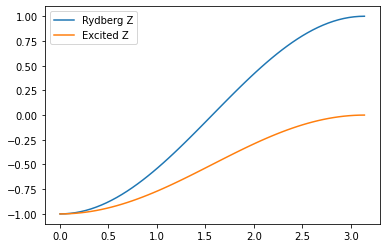

In [9]:
names=['Rydberg Z','Excited Z']
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[i]}")
    
plt.legend()

If we instead evolve with a digital-basis rotation:

In [10]:
H = exc_rotate(1,0,0) #Digital basis
evolution = qutip.sesolve(H, ground, times, [rydZ,excZ])

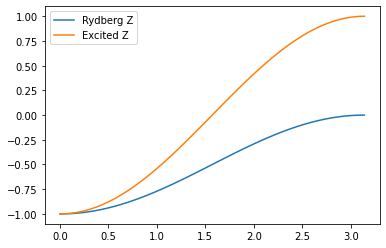

In [11]:
for i,results in enumerate(evolution.expect):
    plt.plot(times,results,label=f"{names[-i]}")
    
plt.legend()

# Two Qutrit System
Now we consider two qutrits: one for control and one for the target of a Control-Z gate. They will also interact via a Van der Waals coupling, which will depend on the physical distance between the two qutrits

In [155]:
gg = qutip.tensor([ground,ground])

ge = qutip.tensor([ground,excited])
eg = qutip.tensor([excited,ground])
ee = qutip.tensor([excited,excited])

gr = qutip.tensor([ground,rydberg])
rg = qutip.tensor([rydberg,ground])
rr = qutip.tensor([excited,rydberg])

In [156]:
#Define Operators
rydN = 0.5*(identity+rydZ)
excN = 0.5*(identity+excZ)

VdW = qutip.tensor([rydN,rydN])
rotation = qutip.tensor([ryd_rotate(1,0,0),identity]) #Rotation in the Ground-Rydberg basis
bias =  qutip.tensor([identity,rydN]) + qutip.tensor([rydN,identity])       

times = np.linspace(0,np.pi,40)
observables = [qutip.tensor([rydZ,identity]),qutip.tensor([identity,rydZ])]


8.499859752314089
1.0
0.0013717421124828531


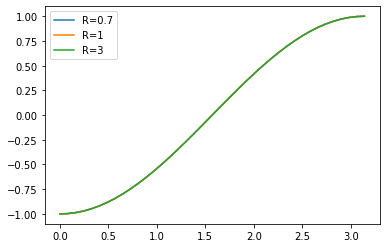

In [157]:
# Try different distances bewteen atoms:
for R in [.7,1,3]:
    print(1/R**6)
    
    H = (1/R**6)*VdW + rotation - 0*bias
    evolution = qutip.sesolve(H, gg, times, observables) # Note that 'gg'=|00〉

    plt.plot(evolution.times, evolution.expect[0],label=f'R={R}')
    
plt.legend()

With this rotation, from the point of view of the ground-rydberg basis, all the population is transfered from the -1 eigenstate (gg) to the +1 eigenstate (rg) of the ZxI observable

# Controlled-Z gate
Now we construct the series of pulses that implement the CZ gate as a sequence. We store the intermediate state after each step

In [158]:
control_rotation = qutip.tensor([ryd_rotate(1,0,0),identity]) #Rotation in the Ground-Rydberg basis
target_rotation = qutip.tensor([identity,ryd_rotate(2,0,0)]) #Rotation in the Ground-Rydberg basis

sequence = {
    "pi pulse control": control_rotation,
    "2pi pulse target": target_rotation, 
    "pi pulse control(again)": control_rotation
    }

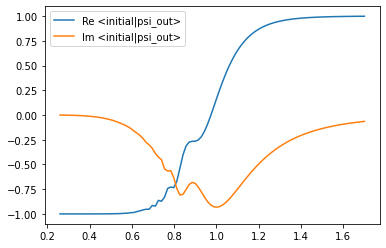

In [164]:
distances = np.linspace(0.26,1.7,100)

evolution_r = []
evolution_i = []

initial = gg # equivalent to |11>

for R in distances:
    
    state = initial # set initial state
    for x in sequence:

        H = (1/R**6)*VdW + sequence[x] - 0*bias
        result = qutip.sesolve(H, state, times) # Without observables, we get the output state
        state = result.states[-1]
    
    scalar_prod = np.vdot(initial.data.toarray(),state.data.toarray())
    evolution_r.append(np.real(scalar_prod))
    evolution_i.append(np.imag(scalar_prod))

plt.plot(distances,evolution_r,label=f"Re <initial|psi_out>")
plt.plot(distances,evolution_i,label=f"Im <initial|psi_out>")
    
plt.legend()
plt.show()

Notice how the phase is negative for particles at small distances (so within the rydberg blockade radius) and positive for particles at large distances. At intermediate distances we have an entangled state

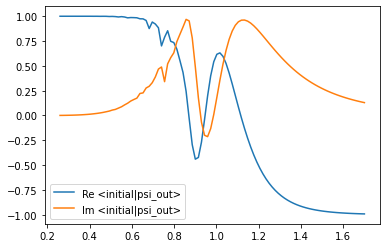

In [163]:
initial = ge # equivalent to |10>

evolution_r = []
evolution_i = []
for R in distances:
    
    state = initial # set initial state
    for x in sequence:

        H = (1/R**6)*VdW + sequence[x] - 0*bias
        result = qutip.sesolve(H, state, times) # Without observables, we get the output state
        state = result.states[-1]
    
    scalar_prod = np.vdot(initial.data.toarray(),state.data.toarray())
    evolution_r.append(np.real(scalar_prod))
    evolution_i.append(np.imag(scalar_prod))

plt.plot(distances,evolution_r,label=f"Re <initial|psi_out>")
plt.plot(distances,evolution_i,label=f"Im <initial|psi_out>")
    
plt.legend()
plt.show()

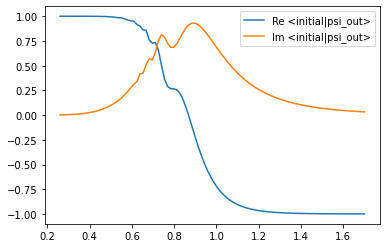

In [162]:
initial = eg # equivalent to |01>

evolution_r = []
evolution_i = []
for R in distances:
    
    state = initial # set initial state
    for x in sequence:

        H = (1/R**6)*VdW + sequence[x] - 0*bias
        result = qutip.sesolve(H, state, times) # Without observables, we get the output state
        state = result.states[-1]
    
    scalar_prod = np.vdot(initial.data.toarray(),state.data.toarray())
    evolution_r.append(np.real(scalar_prod))
    evolution_i.append(np.imag(scalar_prod))

plt.plot(distances,evolution_r,label=f"Re <initial|psi_out>")
plt.plot(distances,evolution_i,label=f"Im <initial|psi_out>")
    
plt.legend()
plt.show()